In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install scikit-plot
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

In [29]:
# Funzione che viene chiamata sul:
# - y_true: target reale
# - y_pred: target predetto dal classificatore
# stampa: matrice di confusione, accuracy, precision, recall, specificity, F1
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")

In [30]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [31]:
df_train = pd.read_csv("/content/Train_NOoutliers")
df_train = df_train.drop(columns=['Unnamed: 0'], axis = 1)
df_train = df_train.drop(columns=['outlier_detection'], axis = 1)
df_test = pd.read_csv("/content/Test_ripulito")
df_test = df_test.drop(columns=['Unnamed: 0'], axis = 1)

In [32]:
df_train_final = df_train[(df_train.emotion != "neutral") & (df_train.emotion != "surprised")]
df_train_final.shape

(1526, 204)

In [33]:
df_test_final = df_test[(df_test.emotion != "neutral") & (df_test.emotion != "surprised")]
df_test_final.shape

(528, 204)

In [34]:
train_positive = []
for value in df_train_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    train_positive.append(1)
  else:
    train_positive.append(0)

In [35]:
test_positive = []
for value in df_test_final['emotion']:
  if((value == 'happy') | (value == 'calm')):
    test_positive.append(1)
  else:
    test_positive.append(0)

In [36]:
df_train_final = df_train_final.assign(positive = train_positive)
df_test_final = df_test_final.assign(positive = test_positive)
#1 se emozioni positive 
#0 se emozioni negative
#neutral e surprised NON incluse

In [37]:
X_train = df_train_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_train = df_train_final[['positive']]
X_test = df_test_final.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename','positive'], axis = 1)
y_test = df_test_final[['positive']]

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# make sure data are np.ndarray
y_train = np.array(y_train)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

PCA

In [46]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

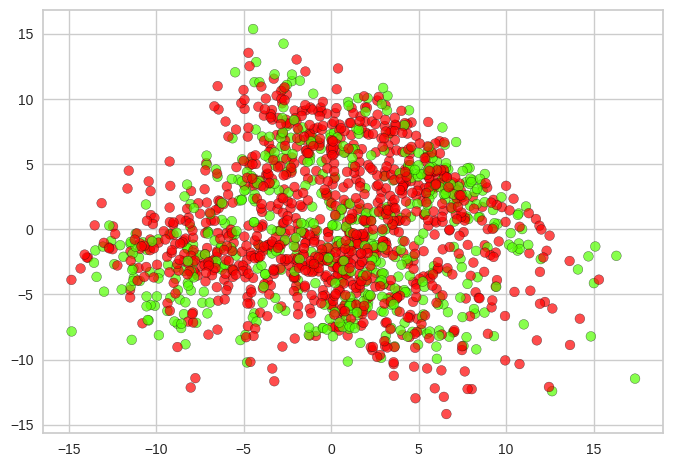

In [52]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

SVM CLASSIFIER


Linear SVM

In [53]:
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings("ignore")

In [54]:
from sklearn.model_selection import GridSearchCV

# Set the parameters by cross-validation
tuned_parameters = {
    'tol':(1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'C': (0.001, 0.05, 0.01, 0.1, 1.0, 10.0, 50, 100.0)
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

scores = ['f1', 'accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    svm = LinearSVC()
    
    clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)
                     
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'C': 50, 'tol': 0.0001}

Grid scores on development set:

0.575 (+/-0.080) for {'C': 0.001, 'tol': 1.0}
0.575 (+/-0.074) for {'C': 0.001, 'tol': 0.1}
0.574 (+/-0.073) for {'C': 0.001, 'tol': 0.01}
0.574 (+/-0.073) for {'C': 0.001, 'tol': 0.001}
0.574 (+/-0.073) for {'C': 0.001, 'tol': 0.0001}
0.574 (+/-0.073) for {'C': 0.001, 'tol': 1e-05}
0.574 (+/-0.073) for {'C': 0.001, 'tol': 1e-06}
0.583 (+/-0.042) for {'C': 0.05, 'tol': 1.0}
0.584 (+/-0.063) for {'C': 0.05, 'tol': 0.1}
0.584 (+/-0.062) for {'C': 0.05, 'tol': 0.01}
0.584 (+/-0.062) for {'C': 0.05, 'tol': 0.001}
0.584 (+/-0.062) for {'C': 0.05, 'tol': 0.0001}
0.584 (+/-0.062) for {'C': 0.05, 'tol': 1e-05}
0.584 (+/-0.062) for {'C': 0.05, 'tol': 1e-06}
0.580 (+/-0.090) for {'C': 0.01, 'tol': 1.0}
0.574 (+/-0.090) for {'C': 0.01, 'tol': 0.1}
0.574 (+/-0.090) for {'C': 0.01, 'tol': 0.01}
0.574 (+/-0.090) for {'C': 0.01, 'tol': 0.001}
0.574 (+/-0.09

**** Matrice di Confusione *****
 True negative: 261 False negative: 81
 True positive: 111 False positive: 75
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.7045
Numero di campioni correttamente correlati:  0.7045454545454546
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.5968
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.5781
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.7768
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.5873
____________________________________________
              precision    recall

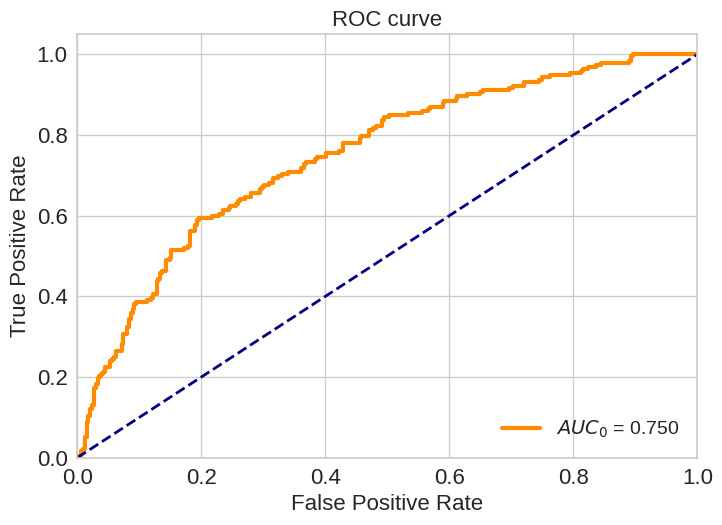

____________________________________
****** VALORE DI AUC *******
0.7496589781746033
____________________________________
****** ROC CURVE: con metodo diretto *******


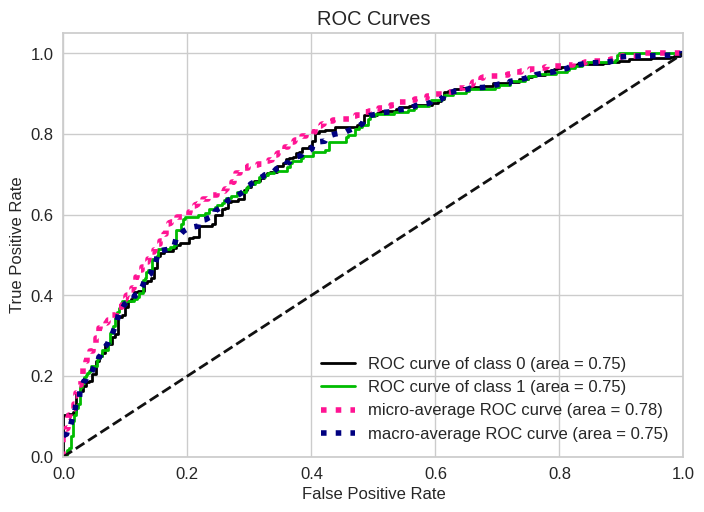

____________________________________
****** Precision recall: con metodo diretto *******


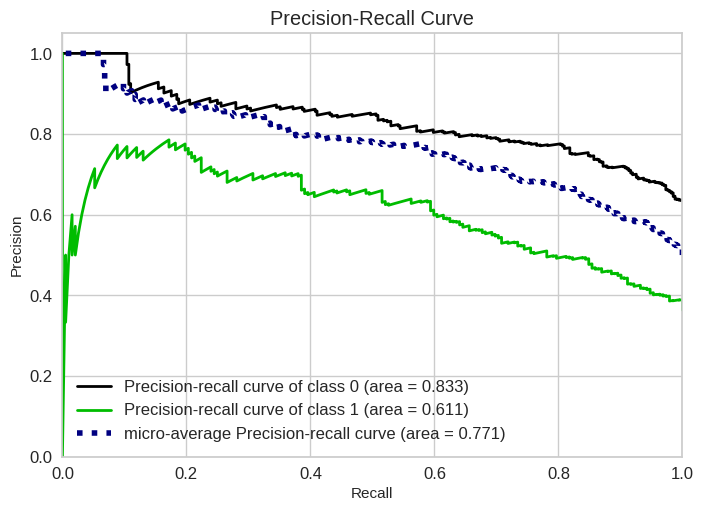

____________________________________
****** Cumulative gain: con metodo diretto *******


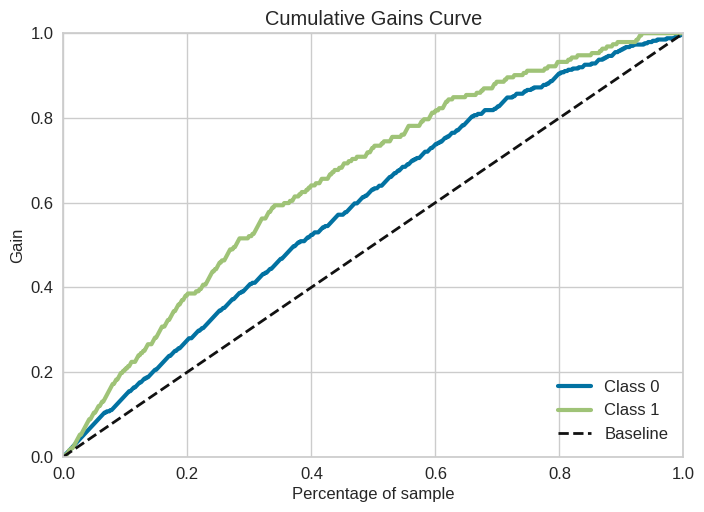

____________________________________
****** Lift curve: con metodo diretto *******


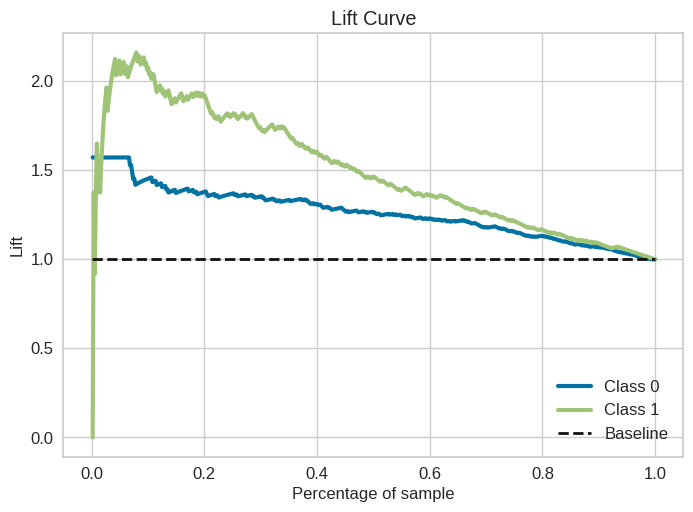

In [55]:
from sklearn.calibration import CalibratedClassifierCV
#{'C': 1.0, 'tol': 0.0001} --> best parameters con f1 
clf = LinearSVC(C=1.0, tol = 0.0001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test,y_pred)
cclf = CalibratedClassifierCV(base_estimator=clf, cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
y_score = cclf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

In [56]:
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]

In [57]:
support_vectors_pca = pca.transform(support_vectors)

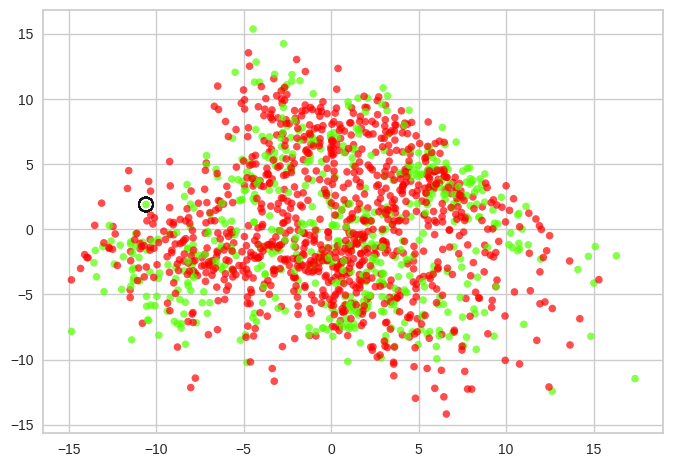

In [58]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [59]:
clf.__dict__

{'dual': True,
 'tol': 0.0001,
 'C': 1.0,
 'multi_class': 'ovr',
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'verbose': 0,
 'random_state': None,
 'max_iter': 1000,
 'penalty': 'l2',
 'loss': 'squared_hinge',
 'n_features_in_': 197,
 'classes_': array([0, 1]),
 'coef_': array([[-1.11480901e-03,  2.42780153e-02, -1.58039805e-01,
         -1.80149819e-01,  1.56095036e-01, -3.30795283e-03,
         -4.39144081e-01, -2.01421015e-02, -3.51094216e-01,
         -1.12067437e-01,  1.84378028e-02, -1.72793325e-01,
          4.82789119e-01,  4.89480430e-02, -3.80912568e-01,
          1.15802228e+00,  1.21938758e+00, -1.92056784e-01,
         -1.02931863e-02, -3.73008174e-01,  1.00483928e-01,
         -4.25448393e-01, -1.80250449e-01, -7.57858761e-02,
          8.62777708e-01,  8.14543007e-01, -2.37911480e-02,
          2.44379100e-01, -6.18128100e-01, -1.66960885e-01,
          1.75852425e-01, -3.68255765e-02, -1.72899420e-01,
         -6.45308257e-04, -3.46366487e-01

NON LINEAR SVM

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Set the parameters by cross-validation
tuned_parameters = {
    'kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
    'C':(0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
    'gamma': (1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    svm = SVC()
    
    clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.349 (+/-0.068) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.685 (+/-0.073) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.349 (+/-0.068) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.646 (+/-0.101) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.349 (+/-0.068) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.349 (+/-0.068) for {'C': 

**** Matrice di Confusione *****
 True negative: 274 False negative: 94
 True positive: 98 False positive: 62
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.7045
Numero di campioni correttamente correlati:  0.7045454545454546
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.6125
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.5104
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.8155
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.5568
____________________________________________
              precision    recall 

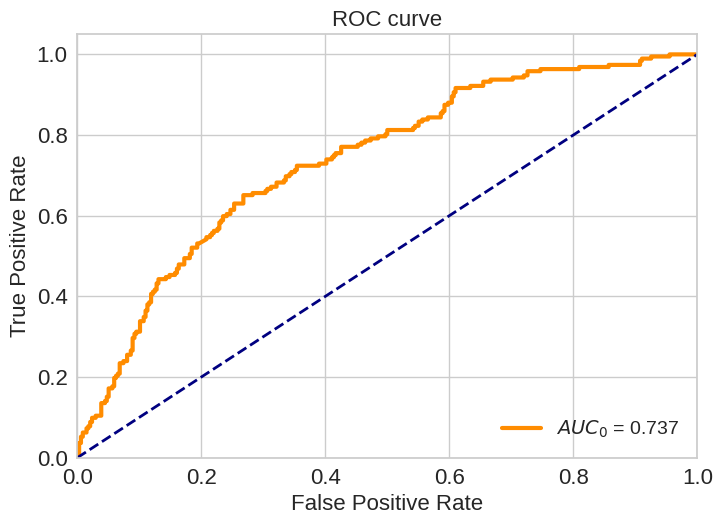

____________________________________
****** VALORE DI AUC *******
0.7372581845238095
____________________________________
****** ROC CURVE: con metodo diretto *******


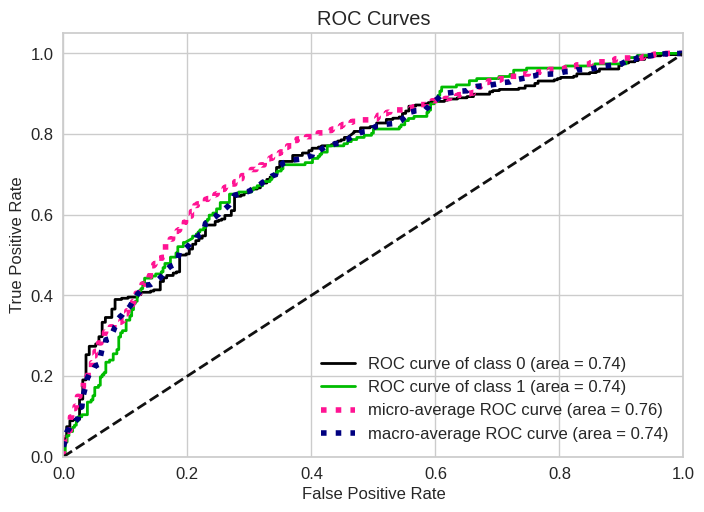

____________________________________
****** Precision recall: con metodo diretto *******


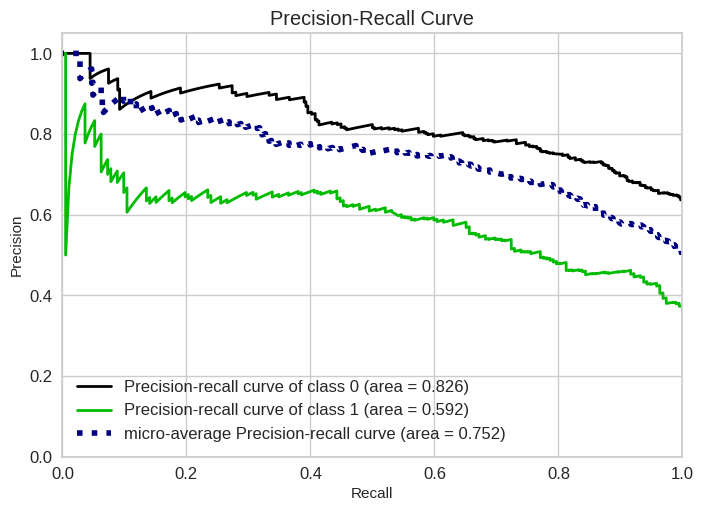

____________________________________
****** Cumulative gain: con metodo diretto *******


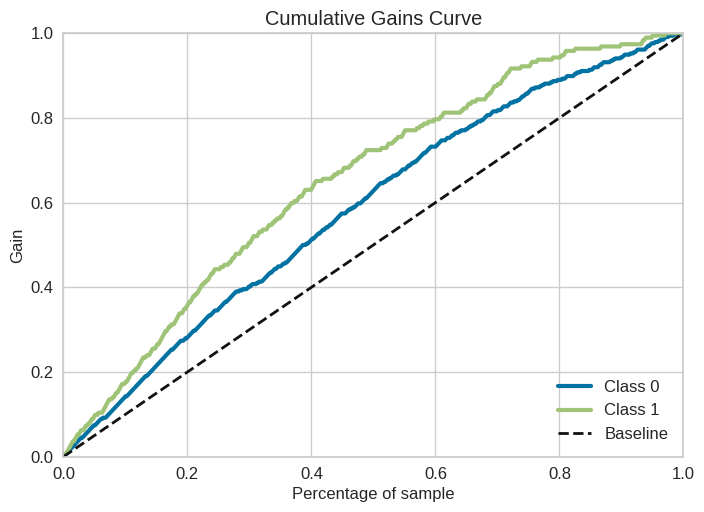

____________________________________
****** Lift curve: con metodo diretto *******


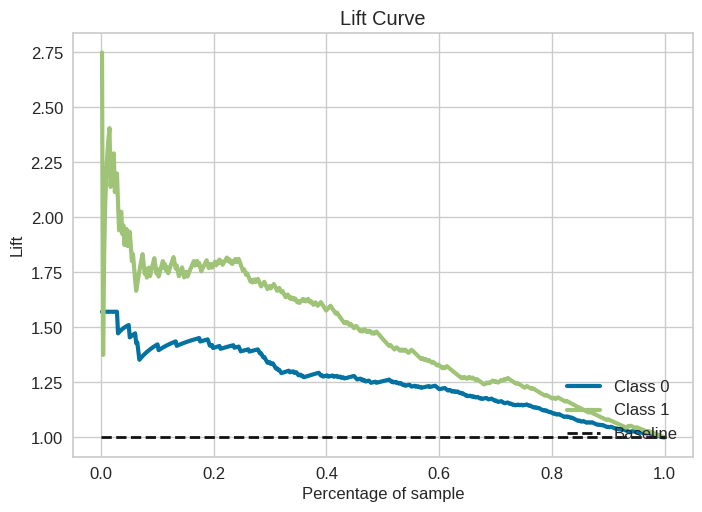

In [61]:
#{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'} best parameters
clf = SVC(gamma=0.01, C=10.0, kernel='rbf', probability= True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)

In [27]:
#con accuracy restituisce stessi valori come con f1 sopra
# Set the parameters by cross-validation
tuned_parameters = {
    'kernel' : ('linear', 'rbf', 'poly', 'sigmoid'),
    'C':(0.001, 0.01, 0.1, 1.0, 10.0, 100.0),
    'gamma': (1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
}
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42, shuffle = True)

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()
    
    svm = SVC()
    
    clf = GridSearchCV(svm, tuned_parameters, error_score='raise', cv=k_fold, scoring=score)
                         
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

# Tuning hyper-parameters for ----> accuracy

Best parameters set found on development set:

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.679 (+/-0.040) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'linear'}
0.637 (+/-0.002) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.784 (+/-0.041) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.679 (+/-0.040) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
0.637 (+/-0.002) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.775 (+/-0.054) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.679 (+/-0.040) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.637 (+/-0.002) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.636 (+/-0.004) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.679 (+/-0.040) for 

In [62]:
clf.support_

array([  16,   17,   18, ..., 1491, 1492, 1493], dtype=int32)

In [63]:
support_vectors_pca = pca.transform(clf.support_vectors_) #[:10]

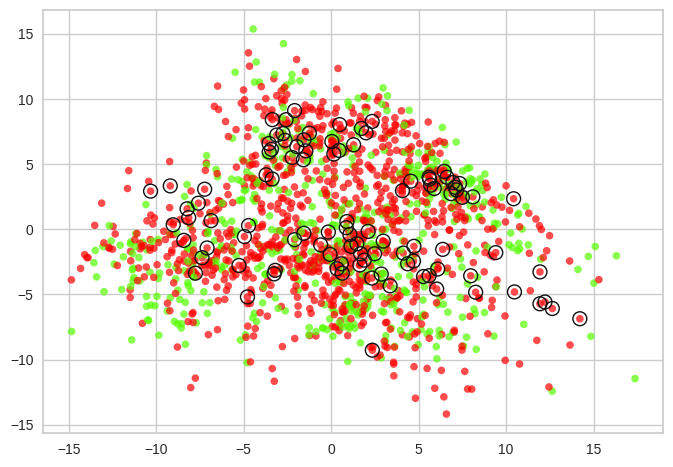

In [64]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
            cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [65]:
clf.n_support_, len(X_train)

(array([748, 509], dtype=int32), 1526)

prova con diversi kernel

In [66]:
#rbf
svm = SVC(kernel = 'rbf', random_state=42)
svm.fit(X_train, y_train)

SVC(random_state=42)

In [67]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       336
           1       0.60      0.51      0.55       192

    accuracy                           0.70       528
   macro avg       0.67      0.66      0.66       528
weighted avg       0.69      0.70      0.69       528



In [68]:
#poly
svm = SVC(kernel = 'poly', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='poly', random_state=42)

In [69]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.72      0.86      0.78       336
           1       0.63      0.41      0.50       192

    accuracy                           0.70       528
   macro avg       0.68      0.64      0.64       528
weighted avg       0.69      0.70      0.68       528



In [70]:
#linear
svm = SVC(kernel = 'linear', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [71]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       336
           1       0.58      0.62      0.60       192

    accuracy                           0.70       528
   macro avg       0.68      0.68      0.68       528
weighted avg       0.70      0.70      0.70       528



In [72]:
#sigmoid
svm = SVC(kernel = 'sigmoid', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='sigmoid', random_state=42)

In [73]:
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72       336
           1       0.51      0.46      0.48       192

    accuracy                           0.64       528
   macro avg       0.61      0.60      0.60       528
weighted avg       0.63      0.64      0.64       528

